# Lab 1: Independent Component Analysis

### Machine Learning 2 (2019)

* The lab exercises can be done in groups of two people, or individually.
* The deadline is Tuesday September 17th, 16:59.
* Assignment should be submitted through Canvas! Make sure to include your and your teammates' names with the submission.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file should be "studentid1\_studentid2\_lab#", for example, the attached file should be "12345\_12346\_lab1.ipynb". Only use underscores ("\_") to connect ids, otherwise the files cannot be parsed.

Notes on implementation:

* You should write your code and answers in an IPython Notebook: http://ipython.org/notebook.html. If you have problems, please ask.
* Use __one cell__ for code and markdown answers only!
    * Put all code in the cell with the ```# YOUR CODE HERE``` comment and overwrite the ```raise NotImplementedError()``` line.
    * For theoretical questions, put your solution using LaTeX style formatting in the YOUR ANSWER HERE cell.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Large parts of you notebook will be graded automatically. Therefore it is important that your notebook can be run completely without errors and within a reasonable time limit. To test your notebook before submission, select Kernel -> Restart \& Run All.

### Literature
In this assignment, we will implement the Independent Component Analysis algorithm as described in chapter 34 of David MacKay's book "Information Theory, Inference, and Learning Algorithms", which is freely available here:
http://www.inference.phy.cam.ac.uk/mackay/itila/book.html

Read the ICA chapter carefuly before you continue!

### Notation

$\mathbf{X}$ is the $M \times T$ data matrix, containing $M$ measurements at $T$ time steps.

$\mathbf{S}$ is the $S \times T$ source matrix, containing $S$ source signal values at $T$ time steps. We will assume $S = M$.

$\mathbf{A}$ is the mixing matrix. We have $\mathbf{X} = \mathbf{A S}$.

$\mathbf{W}$ is the matrix we aim to learn. It is the inverse of $\mathbf{A}$, up to indeterminacies (scaling and permutation of sources).

$\phi$ is an elementwise non-linearity or activation function, typically applied to elements of $\mathbf{W X}$.

### Code
In the following assignments, you can make use of the signal generators listed below.



In [1]:
%pylab inline
import sys
assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed"

# Signal generators
def sawtooth(x, period=0.2, amp=1.0, phase=0.):
    return (((x / period - phase - 0.5) % 1) - 0.5) * 2 * amp

def sine_wave(x, period=0.2, amp=1.0, phase=0.):
    return np.sin((x / period - phase) * 2 * np.pi) * amp

def square_wave(x, period=0.2, amp=1.0, phase=0.):
    return ((np.floor(2 * x / period - 2 * phase - 1) % 2 == 0).astype(float) - 0.5) * 2 * amp

def triangle_wave(x, period=0.2, amp=1.0, phase=0.):
    return (sawtooth(x, period, 1., phase) * square_wave(x, period, 1., phase) + 0.5) * 2 * amp

def random_nonsingular_matrix(d=2):
    """
    Generates a random nonsingular (invertible) matrix of shape d*d
    """
    epsilon = 0.1
    A = np.random.rand(d, d)
    while abs(np.linalg.det(A)) < epsilon:
        A = np.random.rand(d, d)
    return A

def plot_signals(X, title="Signals"):
    """
    Plot the signals contained in the rows of X.
    """
    figure()
    
    for i in range(X.shape[0]):
        ax = plt.subplot(X.shape[0], 1, i + 1)
        plot(X[i, :])
        ax.set_xticks([])
        ax.set_yticks([])
    plt.suptitle(title)

Populating the interactive namespace from numpy and matplotlib


The following code generates some toy data to work with.

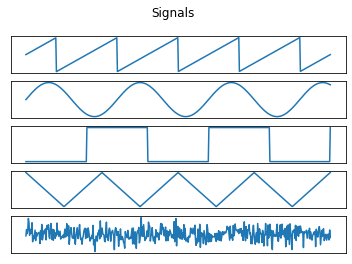

In [2]:
# Generate data
num_sources = 5
signal_length = 500
t = linspace(0, 1, signal_length)
S = np.c_[sawtooth(t), sine_wave(t, 0.3), square_wave(t, 0.4), triangle_wave(t, 0.25), np.random.randn(t.size)].T
plot_signals(S)

### 1.1 Make mixtures (5 points)
Write a function `make_mixtures(S, A)' that takes a matrix of source signals $\mathbf{S}$ and a mixing matrix $\mathbf{A}$, and generates mixed signals $\mathbf{X}$.

In [3]:
### 1.1 Make mixtures
def make_mixtures(S, A):
    return A@S

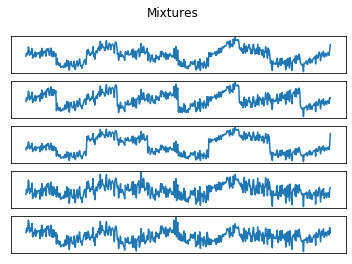

In [4]:
### Test your function
np.random.seed(42)
A = random_nonsingular_matrix(d=S.shape[0])
X = make_mixtures(S, A)
plot_signals(X, "Mixtures")

assert X.shape == (num_sources, signal_length), "The shape of your mixed signals is incorrect"


### 1.2 Histogram (5 points)
Write a function `plot_histograms(X)` that takes a data-matrix $\mathbf{X}$ and plots one histogram for each signal (row) in $\mathbf{X}$. You can use the `np.histogram()` (followed by `plot`) or `plt.hist()` function. 

Plot histograms of the sources and the measurements.

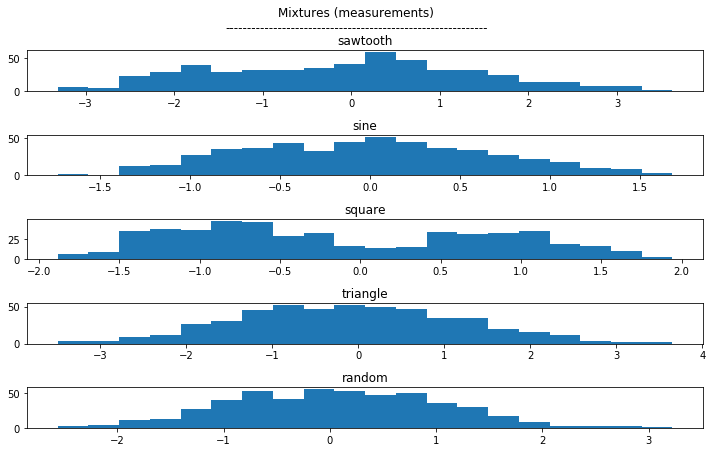

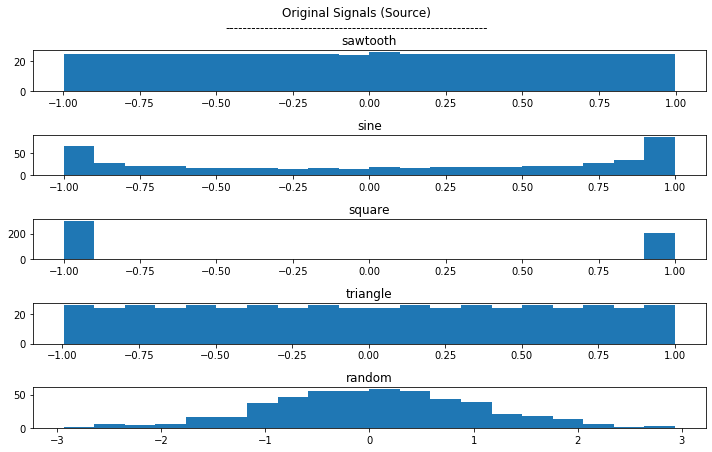

In [5]:
### 1.2 Histogram
# YOUR CODE HERE
signals = ["sawtooth", "sine", "square", "triangle", "random"]
def plot_histograms(X, plt_type):
    f, axes = plt.subplots(X.shape[0], figsize = (10,6))
    f.suptitle(plt_type, y = 1.04)
    
    for i in range(X.shape[0]):
        ax = axes[i]
        ax.hist(X[i, :], bins = 20)
        ax.set_title(signals[i])
    plt.tight_layout()
    
plot_histograms(X, plt_type = 'Mixtures (measurements)\n' + '-'*60)
plot_histograms(S, plt_type = 'Original Signals (Source)\n' + '-'*60)

Which of these distributions (sources or measurements) tend to look more like Gaussians? Can you think of an explanation for this phenomenon? Why is this important for ICA?

***

**ANSWER:**

***Comparing Source with Mixed distribution:*** We see that mixed distributions (measurements) exhibit more Gaussian-like histograms. This is because of the Central Limit Theorem that states that when independent random variables are added, the resultant distribution tends to a normal distribution even if the original distributions were not normal. In our case, we mix 5 random distributions (weighted by $A$) and hence we observe similar behavior.

***Mixed signals:*** The *random mixed signal* looks like Gaussian distribution the most. This is because $np.random.randn$ is used to generate the signal which internally actually uses the standard normal by default to do so. The *sine* and *triangle* mixed distributions come next and this is because they have similar smooth oscillations about $0$ with very less time at the peak values and most of the time spent in transitions. *Sawtooth* is third because of similar behavior but with drastic transitions. The *square* is last as it has 2 modes in original form and switches between them drastically thus spending most of the time at these peaks.

***Source signals:*** The source signals exhibit the least Gaussian like behavior as they are all different distributions and have not been moxed yet for the Central Limit Theorem to apply.

This is not suitable for ICA as the ICA algorithm works under the assumption that the source signals ***do not*** have a Gaussian distribution. 

***

### 1.3 Implicit priors (20 points)
As explained in MacKay's book, an activation function $\phi$ used in the ICA learning algorithm corresponds to a prior distribution over sources. Specifically, $\phi(a) = \frac{d}{da} \ln p(a)$. For each of the following activation functions, *derive* the source distribution they correspond to.
$$\phi_0(a) = -\tanh(a)$$
$$\phi_1(a) = -a + \tanh(a)$$
$$\phi_2(a) = -a^3$$
$$\phi_3(a) = -\frac{6a}{a^2 + 5}$$

Give your answer without the normalizing constant, so an answer of the form $p(a) \propto \verb+[answer]+$ is ok.

**ANSWER**

***
We have,

$\phi(a)=\frac{d}{d a} \ln p(a)$ 

$\Rightarrow \int \phi(a) da=\ln p(a)$

In general, we will also use the following results for the first two part solutions:

$tanh(a) = \frac{\exp^a - \exp^{-a}}{\exp^a + \exp^{-a}}$
$   =  \frac{1 - \exp^{-2a}}{1 + \exp^{-2a}} $

Substituting $y = \exp^{-2a}$

$\Rightarrow a = \frac{-1}{2} \log y$
$\Rightarrow \frac{da}{dy} = \frac{-1}{2y}$
$\Rightarrow da = \frac{-1}{2y} dy$

Thus,

$tanh(a) = \frac{-1}{2} \int \frac{1 - y}{(1 + y)y}dy$

***

***
**1) $\ \ \  \phi_0(a)= -tanh(a)$**

$\Rightarrow \int \phi(a)da = -\int tanh(a) da$

$ =  \frac{1}{2} \int \frac{1 - y}{(1 + y)y} dy$

$ = \frac{1}{2} \int \frac{1 + y - 2y}{(1 + y)y} dy$

$ = \frac{1}{2} \int \frac{1 + y}{(1 + y)y}dy - \frac{1}{2} \int \frac{2y}{(1 + y)y}dy$

$ = \frac{1}{2} \int \frac{1}{y}dy - \int \frac{1}{(1 + y)}dy$

$ = \frac{1}{2} \ln y - \ln (1+y) + c$

$ = -a - \ln (1 + \exp^{-2a}) + c$

Thus,

$\ln p(a) = -a - \ln (1 + \exp^{-2a}) + c$

$p(a) = \exp{-a - \ln (1 + \exp^{-2a}) + c}$

$p(a) = \frac{\exp^c} {\exp^a \cdot (1 + \exp^{-2a})}$

$p(a) \propto \frac{1} {\exp^a \cdot (1 + \exp^{-2a})}$

***

***
**2) $\ \ \  \phi_1(a)= -a + tanh(a)$**

$\Rightarrow \int \phi(a)da = \int -a da + \int tanh(a) da$

Following similar steps as above, we arrive at:

$\ln p(a) = -\int a d a- (-a-\ln (1+e^{-2 a})+c)=-\frac{1}{2} a^{2}+a+\ln (1+e^{-2 a})+c$

Hence,

$p(a) \propto e^{-\frac{1}{2} a^{2}+a}+e^{-\frac{1}{2} a^{2}-a}$

***

***
**3)$\ \ \  \phi_2(a)= -a^3$**

$\Rightarrow \int \phi(a)da = \int -a^3 da$

$ = \frac{-1}{4}a^4 + c$

Thus,

$p(a) \propto \exp^{\frac {-1}{4}a^4}$

***

***
**4)$\ \ \  \phi_3(a)= - \frac{6a}{a^2 + 5}$**

$\Rightarrow \int \phi(a)da = \int-\frac{6 a}{a^{2}+5} da$

$ = -3\int \frac{2a}{a^2 + 5}da$

$= -3\ln |a^2+5|+c$

Thus,

$p(a) \propto (a^2 + 5)^{-3}$
***

In [6]:
def phi_0(a):
    return -np.tanh(a)

def p_0(a):
    return np.exp(-a)/ (1 + np.exp(-2*a))

In [7]:
def phi_1(a):
    return -a + np.tanh(a)

def p_1(a):
    return np.exp(-0.5 * (a**2 + a)) + np.exp(-0.5 * (a**2 - a))

In [8]:
def phi_2(a):
    return -a**3

def p_2(a):
    return np.exp(-0.25 * (a**4))

In [9]:
def phi_3(a):
    return -6*a / (a**2 + 5)

def p_3(a):
    return (a**2 + 5)**(-3)

In [10]:
activation_functions = [phi_0, phi_1, phi_2, phi_3]
priors = [p_0, p_1, p_2, p_3]

a = np.linspace(-5, 5, 1000)
for prior in priors:
    assert prior(a).shape == (1000, ), "Wrong output shape"


Plot the activation functions and the corresponding prior distributions, from $a = -5$ to $5$ (hint: use the lists defined in the cell above). Compare the shape of the priors to the histogram you plotted in the last question.

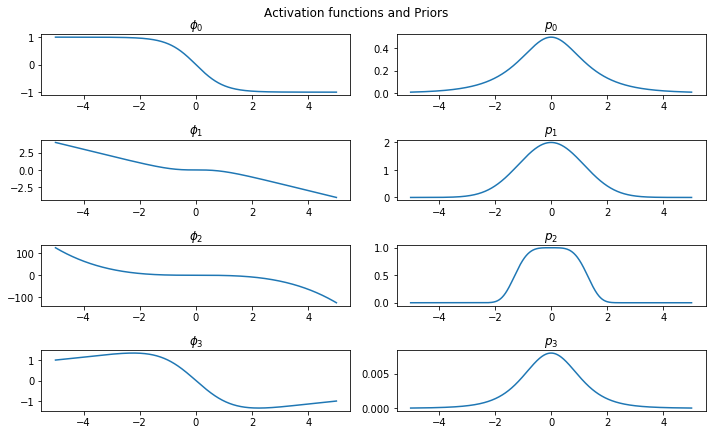

In [11]:
### 1.3 Implicit priors (continued)
a = np.linspace(-5, 5, 1000)

def plot_activ_n_priors():
    f, axes = plt.subplots(len(priors), 2 , figsize = (10,6))
    f.suptitle("Activation functions and Priors", y=1)
    
    for i, prior in enumerate(priors):
        ax = axes[i][0]
        ax.plot(a, activation_functions[i](a))
        ax.set_title('$\phi_{}$'.format(i))

        ax = axes[i][1]
        ax.plot(a, priors[i](a))
        ax.title.set_text('$p_{}$'.format(i))
    plt.tight_layout()
    return None

plot_activ_n_priors()

***
**ANSWER:**

We see that all the activation funcitons correspond to priors that more or less look like the standard normal (Gaussian). These prior distributions correspond the most to the ***random*** source signal shape. Amongst the priors, the $p_0$ and $p_3$ look the most like a standrad Normal (due to their bell shape and the tail).
***

### 1.4 Whitening (15 points)
Some ICA algorithms can only learn from whitened data. Write a method `whiten(X)` that takes a $M \times T$ data matrix $\mathbf{X}$ (where $M$ is the dimensionality and $T$ the number of examples) and returns a whitened matrix. If you forgot what whitening is or how to compute it, various good sources are available online, such as http://courses.media.mit.edu/2010fall/mas622j/whiten.pdf. Your function should also center the data before whitening.

***
$cov[X] = \frac{1}{n-1} \sum_{i=1}^{n}\left(x_{i}-\overline{x}\right)^{2}$, where $\overline{x}=$ mean of x

$\mathbf{whitened(x)} = \boldsymbol{\Lambda}^{-1 / 2} \boldsymbol{\Phi}^{T} \mathbf{x}$

***

In [12]:
### 1.4 Whitening
def whiten(X):
    X = X.T
    
    # Getting the cov matrix of X
    X = X - np.mean(X, axis=0)
    X_cov = X.T@X /X.shape[1]
    
    # eigenvalue decomposition of the covariance matrix
    [eig_vals, eig_vecs] = np.linalg.eigh(X_cov)
    
    # Square-root of the inverse of the eigenvalue matrix
    sqrt_inv_lamda = np.diag(1.0 /np.sqrt(eig_vals))
    
    # whitening matrix
    W = (eig_vecs @ sqrt_inv_lamda) @ eig_vecs.T

    # multiply by the whitening matrix
    X_whitened = X @ W
    
    return X_whitened.T

In [13]:
### Test your function
Xw = whiten(X)
assert Xw.shape == (num_sources, signal_length), "The shape of your mixed signals is incorrect"


### 1.5 Interpret results of whitening (10 points)
Make 3 figures, one for the sources, one for measurements and one for the whitened measurements. In each figure, make $5 \times 5$ subplots with scatter plots for each pair of signals. Each axis represents a signal and each time-instance is plotted as a dot in this space. You can use the `plt.scatter()` function. Describe what you see.

Now compute and visualize the covariance matrix of the sources, the measurements and the whitened measurements. You can visualize each covariance matrix using this code:
```python
# Dummy covariance matrix C;
C = np.eye(5)  
ax = imshow(C, cmap='gray', interpolation='nearest')
```

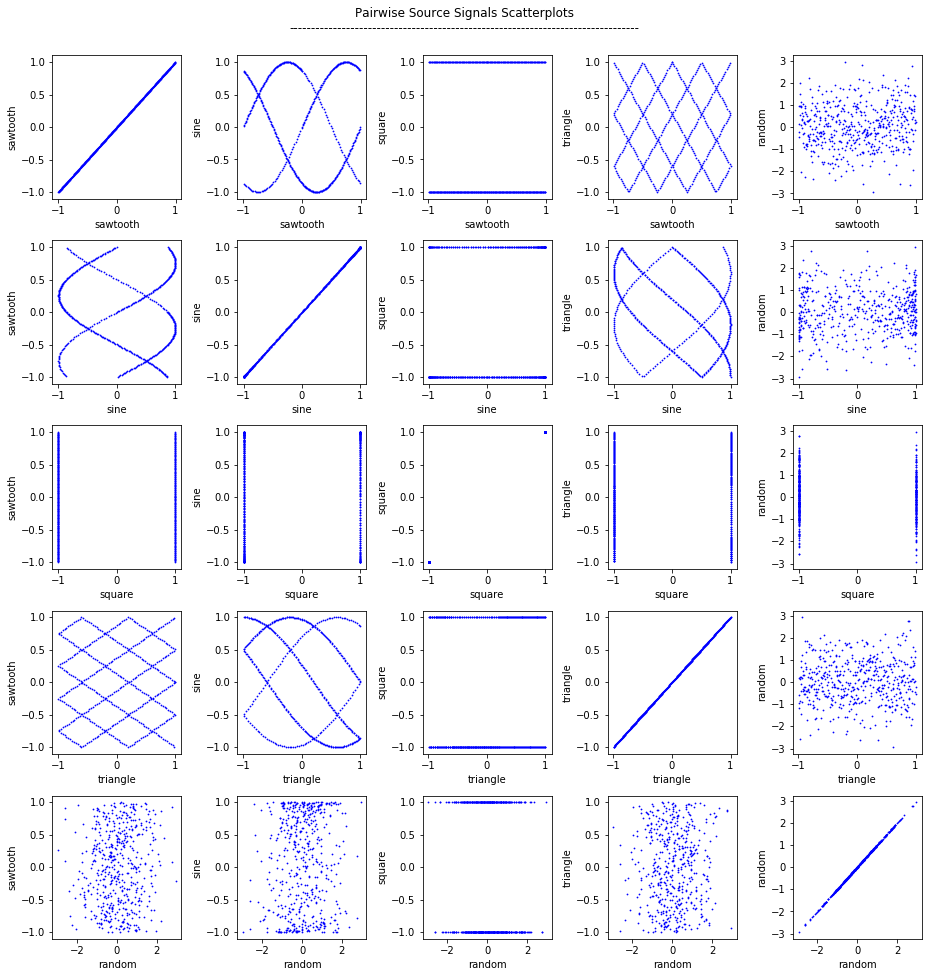

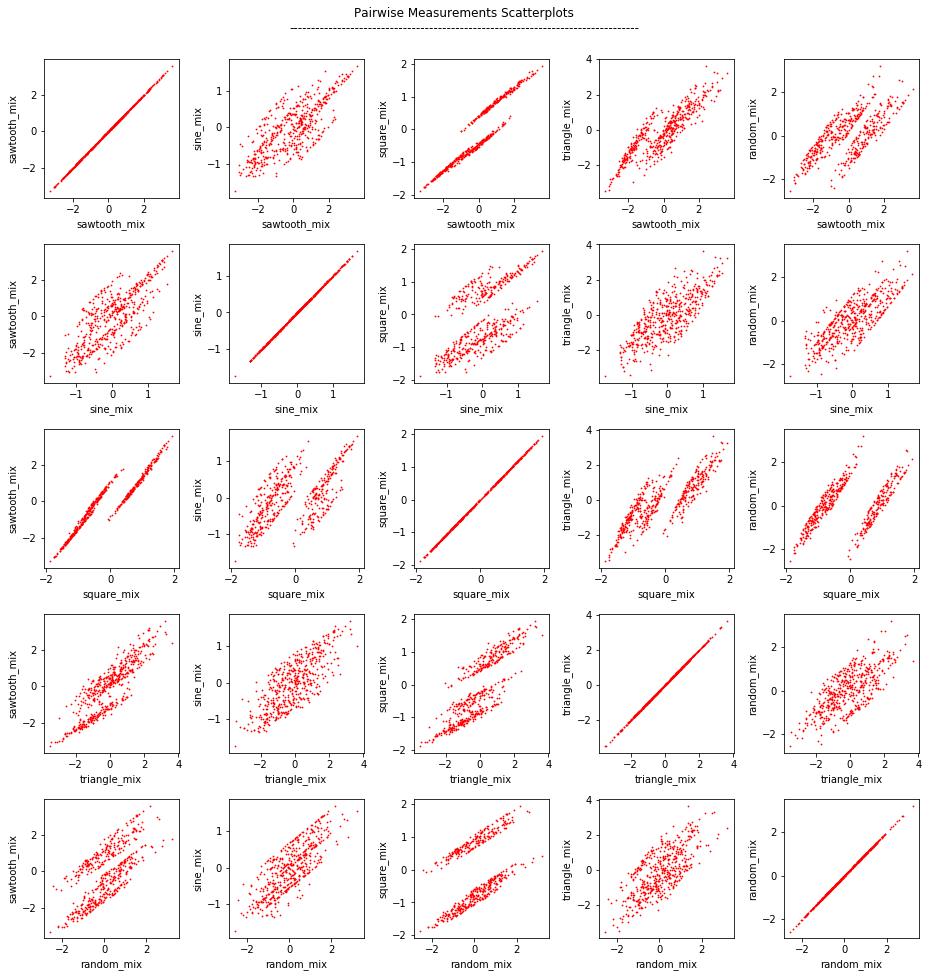

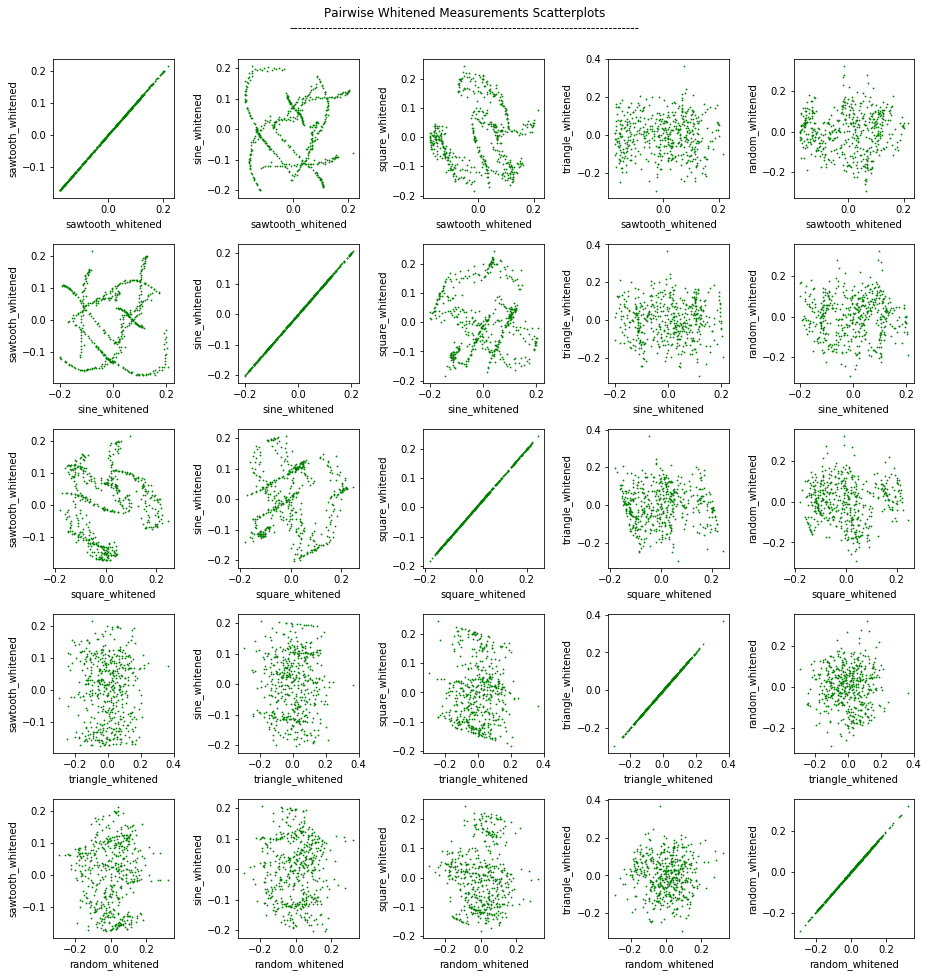

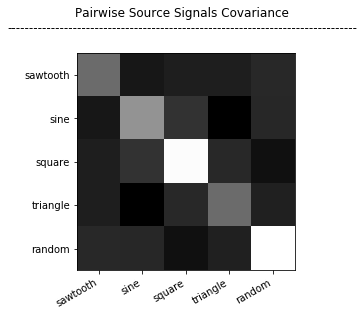

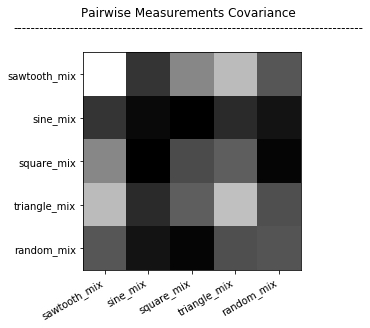

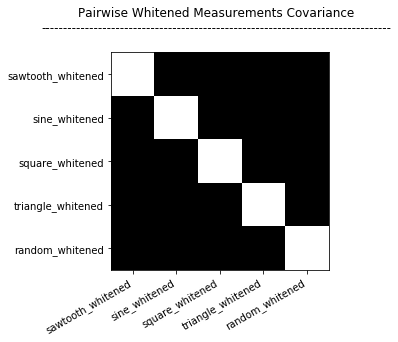

In [14]:
### 1.5 Interpret results of whitening

mixtures = []
mix_whiten = []
scatter_colors = ['b' , 'r', 'g']

for s in signals:
    mixtures.append(s+'_mix')
    mix_whiten.append(s+'_whitened')


def plot_scatter(X, title, subtitles=[], count=0):
    
    dim = X.shape[0]
    f, axes = plt.subplots(dim, dim, figsize=(13, 13))
    f.suptitle(title + "\n" + "-"*80, y=1.04)
    
    for row in range(dim):
        for col in range(dim):
            ax = axes[row,col]
            ax.scatter(X[row, :],X[col, :], s= 0.6, c= scatter_colors[count])
            ax.set_xlabel(subtitles[row])
            ax.set_ylabel(subtitles[col])
    
    plt.tight_layout()
    return None
    
    
def plot_covariance(X, title, labels=[]):
    
    f, ax = plt.subplots(1, figsize=(4, 4))
    f.suptitle(title + "\n" + "-"*80, y=1.04)
    
    C = np.cov(X) 
    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels(labels,rotation = 30, horizontalalignment="right")
    ax.set_yticks([0,1,2,3,4])
    ax.set_yticklabels(labels)
    ax = imshow(C, cmap='gray', interpolation='nearest')  

# Plotting Pairwise Scatterplots   
plot_scatter(S, 'Pairwise Source Signals Scatterplots', signals,0)
plot_scatter(X, 'Pairwise Measurements Scatterplots', mixtures,1)
plot_scatter(Xw, 'Pairwise Whitened Measurements Scatterplots', mix_whiten,2)

# Plotting Pairwise Covariance
plot_covariance(S, "Pairwise Source Signals Covariance", signals)
plot_covariance(X, "Pairwise Measurements Covariance", mixtures)
plot_covariance(Xw, "Pairwise Whitened Measurements Covariance", mix_whiten)

Are the signals independent after whitening?

***

**ANSWER:**

Yes the whitened signals are de-correlated, ie, are independent. We can see this in the scatterplot as well as the covariance matrix. The scatterplots before show clear linear correlation between measurement pairs. This is also confirmed from the covariance matrix that has patches (and/or shades) of white all over, where white denotes $1$ (highest correlation) and black denotes $0$ (negative correlation). 

After whitening, we can see the scatter plots are all blobs with no apparent rotation visible. Even the covariance matrix has white patches only on the diagonals (obvious high correlation with self) and no correaltion with others (black everywhere).

***

### 1.6 Covariance (5 points)
Explain what a covariant algorithm is. 

YOUR ANSWER HERE

### 1.7 Independent Component Analysis (25 points)
Implement the covariant ICA algorithm as described in MacKay. Write a function `ICA(X, activation_function, learning_rate)`, that returns the demixing matrix $\mathbf{W}$. The input `activation_function` should accept a function such as `lambda a: -tanh(a)`. Update the gradient in batch mode, averaging the gradients over the whole dataset for each update. Make it efficient, so use matrix operations instead of loops where possible (loops are slow in interpreted languages such as python and matlab, whereas matrix operations are internally computed using fast C code). Experiment with the learning rate and the initialization of $\mathbf{W}$. Your algorithm should be able to converge (i.e. `np.linalg.norm(grad) < 1e-5`) in within 10000 steps.

In [15]:
### 1.7 Independent Component Analysis
def ICA(X, activation_function, learning_rate=0.1, steps = 10000, w_init_type = 'random'):
    print("\nRunning {} ...\n".format(activation_function))
    
    if w_init_type == 'nonsingular':
        W = random_nonsingular_matrix(X.shape[0])
    elif w_init_type == 'random':
        W = np.random.randn(X.shape[0], X.shape[0])
    else:
        raise ValueError("[!] Error: invalid w_init_type argument !!")
    
    for iters in range(steps):
        A = W@X
        Z = activation_function(A)
        X_new = W.T@A
        
        grad = W + Z@X_new.T/X.shape[1]
        grad_norm = np.linalg.norm(grad.flatten())
        
        if grad_norm < 1e-5 or np.isnan(grad_norm):
            print("\nGrad Norm went below 1e-5 or NaN!! Aborting..\n")
            break
            
        W = W + learning_rate*grad
        if iters%1000==0:
            print("Step: {},   Grad_norm = {}".format(iters, grad_norm))
    
    print("Total steps until termination = {}, Grad_norm = {}\n".format(iters+1, grad_norm) + "-"*100)
    return W
            

W_est = ICA(Xw, phi_3, learning_rate=0.5)  # Compare with ICA(X)

# W_estimates = [ICA(Xw, activation_function=phi, learning_rate=0.5, w_init_type='nonsingular') for phi in activation_functions]
# assert all([W_est.shape == (num_sources, num_sources) for W_est in W_estimates])



Running <function phi_3 at 0x7f9e64569f28> ...

Step: 0,   Grad_norm = 4.699996053951218
Step: 1000,   Grad_norm = 1.892957268833063e-05

Grad Norm went below 1e-5 or NaN!! Aborting..

Total steps until termination = 1051, Grad_norm = 9.920002141861714e-06
----------------------------------------------------------------------------------------------------


In [16]:
# We will test your function so make sure it runs with only X and phi as input, and returns only W
# Also it should converge for all activation functions

W_estimates = [ICA(Xw, activation_function=phi, learning_rate=1.0) for phi in activation_functions]
assert all([W_est.shape == (num_sources, num_sources) for W_est in W_estimates])



Running <function phi_0 at 0x7f9e63d2d048> ...

Step: 0,   Grad_norm = 3.8886108831979276
Step: 1000,   Grad_norm = 10.717349363216568
Step: 2000,   Grad_norm = 10.717349363207864
Step: 3000,   Grad_norm = 10.717349363207873
Step: 4000,   Grad_norm = 10.71734936320788
Step: 5000,   Grad_norm = 10.71734936320788
Step: 6000,   Grad_norm = 10.717349363207886
Step: 7000,   Grad_norm = 10.717349363207884
Step: 8000,   Grad_norm = 10.71734936320788
Step: 9000,   Grad_norm = 10.71734936320788
Total steps until termination = 10000, Grad_norm = 10.71734936320788
----------------------------------------------------------------------------------------------------

Running <function phi_1 at 0x7f9e63d2d488> ...

Step: 0,   Grad_norm = 4.582083898513489
Step: 1000,   Grad_norm = 15.221672337315123
Step: 2000,   Grad_norm = 11.918217864126325
Step: 3000,   Grad_norm = 16.633824579711224
Step: 4000,   Grad_norm = 13.675995663777481
Step: 5000,   Grad_norm = 15.022734463166968
Step: 6000,   Grad_norm

/home/shaan/anaconda3/envs/ml2labs/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in power
  
/home/shaan/anaconda3/envs/ml2labs/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in matmul
/home/shaan/anaconda3/envs/ml2labs/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in matmul
  del sys.path[0]


Step: 0,   Grad_norm = 4.339339717316049
Step: 1000,   Grad_norm = 7.554533132507945
Step: 2000,   Grad_norm = 7.554533132521539
Step: 3000,   Grad_norm = 7.554533132521535
Step: 4000,   Grad_norm = 7.554533132521533
Step: 5000,   Grad_norm = 7.554533132521538
Step: 6000,   Grad_norm = 7.554533132521535
Step: 7000,   Grad_norm = 7.554533132521525
Step: 8000,   Grad_norm = 7.554533132521539
Step: 9000,   Grad_norm = 7.554533132521533
Total steps until termination = 10000, Grad_norm = 7.55453313252153
----------------------------------------------------------------------------------------------------


### 1.8 Experiments  (5 points)
Run ICA on the provided signals using each activation function $\phi_0, \ldots, \phi_3$ (or reuse `W_estimates`). Use the found demixing matrix $\mathbf{W}$ to reconstruct the signals and plot the retreived signals for each choice of activation function.

				 Obtaining the W_estimates

Running <function phi_0 at 0x7f9e63d2d048> ...

Step: 0,   Grad_norm = 3.9783364180564824
Step: 1000,   Grad_norm = 0.02687456752442933
Step: 2000,   Grad_norm = 0.013092397053309524
Step: 3000,   Grad_norm = 0.007545771630794214
Step: 4000,   Grad_norm = 0.004241515254185065
Step: 5000,   Grad_norm = 0.0022542086349674494
Step: 6000,   Grad_norm = 0.0011495436347500612
Step: 7000,   Grad_norm = 0.0005724127825736085
Step: 8000,   Grad_norm = 0.0002814916896578933
Step: 9000,   Grad_norm = 0.0001375591696752944
Total steps until termination = 10000, Grad_norm = 6.706198178305958e-05
----------------------------------------------------------------------------------------------------

Running <function phi_1 at 0x7f9e63d2d488> ...

Step: 0,   Grad_norm = 4.9886520216849135
Step: 1000,   Grad_norm = 0.0892085668056362
Step: 2000,   Grad_norm = 0.00017146345477792087

Grad Norm went below 1e-5 or NaN!! Aborting..

Total steps until termination = 2428, Grad_n

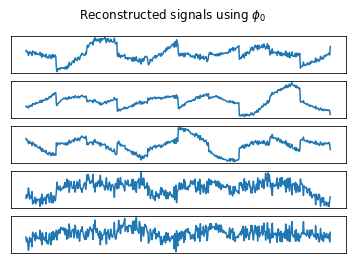

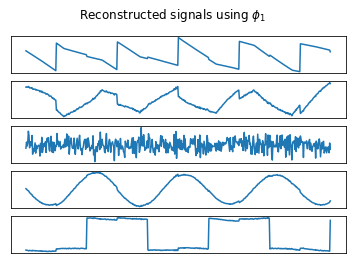

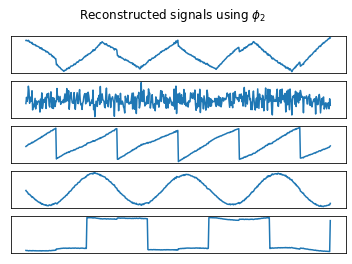

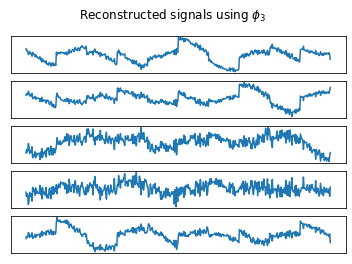

In [20]:
# 1.8 Experiments

print("="*100 + "\n\t\t\t\t Obtaining the W_estimates\n" + "="*100)
W_estimates = [ICA(Xw, activation_function=phi, learning_rate=0.1, w_init_type='random') for phi in activation_functions]

print("\n\n" +"="*100 + "\n\t\t\t\t Reconstructing the Source signals\n" + "="*100)
for i in range(len(W_estimates)):
    W_now = W_estimates[i]
    s_obtained = W_now@Xw
    plot_signals(s_obtained, "Reconstructed signals using $\phi_{}$".format(i))

In [18]:
def does_whitening_make_a_difference():
    # Does it make a difference (in terms of speed of convergence) 
    # if you whiten your data before running ICA?
    
    # Return True or False
    # YOUR CODE HERE
    raise NotImplementedError()

In [19]:
assert type(does_whitening_make_a_difference()) == bool

NotImplementedError: 

### 1.9 Audio demixing (10 points)
The 'cocktail party effect' refers to the ability humans have to attend to one speaker in a noisy room. We will now use ICA to solve a similar but somewhat idealized version of this problem. The code below loads 5 sound files and plots them.

Use a random non-singular mixing matrix to mix the 5 sound files. You can listen to the results in your browser using `play_signals`, or save them to disk if this does not work for you. Plot histograms of the mixed audio and use your ICA implementation to de-mix these and reproduce the original source signals. As in the previous exercise, try each of the activation functions.

Keep in mind that this problem is easier than the real cocktail party problem, because in real life there are often more sources than measurements (we have only two ears!), and the number of sources is unknown and variable. Also, mixing is not instantaneous in real life, because the sound from one source arrives at each ear at a different point in time. If you have time left, you can think of ways to deal with these issues.

In [ ]:
import scipy.io.wavfile
from IPython.display import Audio, display, Markdown

# Save mixtures to disk, so you can listen to them in your audio player
def save_wav(data, out_file, rate):
    scaled = np.int16(data / np.max(np.abs(data)) * 32767)
    scipy.io.wavfile.write(out_file, rate, scaled)

# Or play them in your browser
def play_signals(S, sample_rate, title="Signals"):
    display(Markdown(title))
    for signal in S:
        display(Audio(signal, rate=sample_rate))

In [ ]:
# Load audio sources
source_files = ['beet.wav', 'beet9.wav', 'beet92.wav', 'mike.wav', 'street.wav']
wav_data = []
sample_rate = None
for f in source_files:
    sr, data = scipy.io.wavfile.read(f, mmap=False)
    if sample_rate is None:
        sample_rate = sr
    else:
        assert(sample_rate == sr)
    wav_data.append(data[:190000])  # cut off the last part so that all signals have same length

# Create source and measurement data
S_audio = np.c_[wav_data]
plot_signals(S_audio)
play_signals(S_audio, sample_rate)

In [ ]:
### 1.9 Audio demixing
# YOUR CODE HERE
raise NotImplementedError()

Report your results. Using which activation functions ICA recovers the sources?

YOUR ANSWER HERE

### 1.10 Excess Kurtosis (15 points)
The (excess) kurtosis is a measure of 'peakedness' of a distribution. It is defined as
$$
\verb+Kurt+[X] = \frac{\mu_4}{\sigma^4} - 3 = \frac{\operatorname{E}[(X-{\mu})^4]}{(\operatorname{E}[(X-{\mu})^2])^2} - 3
$$
Here, $\mu_4$ is known as the fourth moment about the mean, and $\sigma$ is the standard deviation.
The '-3' term is introduced so that a Gaussian random variable has 0 excess kurtosis.
We will now try to understand the performance of the various activation functions by considering the kurtosis of the corresponding priors, and comparing those to the empirical kurtosis of our data.

#### 1.10.1 (10 points)
First, compute analytically the kurtosis of the four priors that you derived from the activation functions before. You may find it helpful to use an online service such as [Wolfram Alpha](https://www.wolframalpha.com/) or [Integral Calculator](https://www.integral-calculator.com/) to (help you) evaluate the required integrals. Give your answer as both an exact expression as well as a numerical approximation (for example $\frac{\pi}{2} \approx 1.571$).

YOUR ANSWER HERE

In [ ]:
### Include your answer here (you can use math.gamma if needed)
def get_kurtosis():
    # Return a list with 4 numbers / expressions
    # return [0, 0, 0, 0]
    
    # YOUR CODE HERE
    raise NotImplementedError()
    

In [ ]:
# Let's check
kurtosis = get_kurtosis()
print (kurtosis)
assert len(kurtosis) == 4


#### 1.10.2 (5 points)
Now use the `scipy.stats.kurtosis` function, with the `fisher` option set to `True`, to compute the empirical kurtosis of the dummy signals and the real audio signals.

Can you use this data to explain the performance of the various activation functions on the synthetic and real data?

In [ ]:
### 1.10.2 Excess Kurtosis
# YOUR CODE HERE
raise NotImplementedError()

YOUR ANSWER HERE